# Doubling

(64,)
40
[[ 0.  1.  2.  3.  4.  5.  6.  7.]
 [ 8.  9. 10. 11. 12. 13. 14. 15.]
 [16. 17. 18. 19. 20. 21. 22. 23.]
 [24. 25. 26. 27. 28. 29. 30. 31.]
 [32. 33. 34. 35. 36. 37. 38. 39.]
 [23. 24. 25. 26. 18. 19. 20. 21.]
 [18. 19. 20. 21. 13. 14. 15. 16.]
 [13. 14. 15. 16.  8.  9. 10. 11.]]


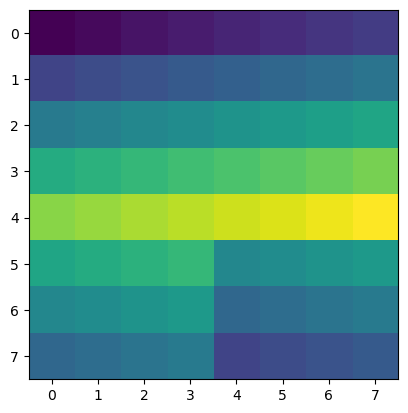

In [1]:
import numpy as np
ntheta = 8
nphi = 10
synth1D = np.arange((ntheta * nphi))
doubling1D_py = np.zeros((2 * ntheta-2, nphi))
print(doubling1D_py.flatten().shape)
synth1D_py = np.copy(synth1D.reshape(ntheta, nphi))
print(synth1D_py.shape, doubling1D_py[:ntheta, :].shape)

nphihalf = nphi//2
doubling1D_py[:ntheta, :] = synth1D_py
doubling1D_py[ntheta:, :nphihalf] = doubling1D_py[ntheta-2:0:-1, nphihalf:]
doubling1D_py[ntheta:, nphihalf:] = doubling1D_py[ntheta-2:0:-1, :nphihalf]

doubling1D_py

In [135]:
import numpy as np
synth1D = np.arange((ntheta * nphi))
doubling1D = np.zeros(((2 * ntheta - 2)* nphi))
import matplotlib.pyplot as plt
nphihalf = nphi // 2

ringi = 0

for ringi in range(ntheta):
    for phii in range(nphi):
        doubling1D[ringi * nphi + phii] = synth1D[ringi * nphi + phii]
for ringi in range(ntheta, 2 * ntheta-2, 1):
    for phii in range(0, nphi):
        if phii<nphihalf:
            doubling1D[ringi * nphi + phii] = synth1D[(2*ntheta-2)*nphi - ringi*nphi + phii + nphihalf]
        else:
            doubling1D[ringi * nphi + phii] = synth1D[(2*ntheta-2)*nphi - (ringi+1)*nphi + phii + nphihalf]

fig, ax = plt.subplots(1,3,figsize=(14,6))
ax[0].imshow(doubling1D_py)
ax[0].set_title('Truth')
ax[1].imshow(doubling1D.reshape(2*ntheta - 2, nphi))
ax[1].set_title("Trial")
ax[2].imshow(doubling1D_py-doubling1D.reshape(2*ntheta - 2, nphi), cmap="PiYG", vmin=-10, vmax=10)

(doubling1D_py) - (doubling1D.reshape(2*ntheta - 2, nphi))

[[ 0.  1.  2.  3.  4.  5.  6.  7.]
 [ 8.  9. 10. 11. 12. 13. 14. 15.]
 [16. 17. 18. 19. 20. 21. 22. 23.]
 [24. 25. 26. 27. 28. 29. 30. 31.]
 [32. 33. 34. 35. 36. 37. 38. 39.]
 [28. 29. 30. 31. 24. 25. 26. 27.]
 [20. 21. 22. 23. 16. 17. 18. 19.]
 [12. 13. 14. 15.  8.  9. 10. 11.]]


# integration spin1 - pointing

In [11]:
import cupy as cp
import numpy as np
import shtns
import matplotlib.pyplot as plt
from pysht.c.podo_interface import Cpointing_ptrs, Cpointing_cparr, Cpointing_1Dto1D
from ducc0.misc import get_deflected_angles

import pysht
import healpy as hp

input_value = None
def input_values(lmax, geom):
    npix = int(lmax+1)*2*(lmax+1)
    # thetas = cp.linspace(0, np.pi, lmax+1, dtype=cp.float64)+0.0122479
    thetas = cp.array(geom.theta.astype(cp.float64))
    # phi0 = cp.zeros(lmax+1, dtype=cp.float64)
    phi0 = cp.array(geom.phi0.astype(cp.float64))
    # ringstarts = cp.linspace(0, npix-npix//(lmax+1), lmax+1, dtype=np.uint64)
    ringstarts = cp.array(geom.ofs.astype(cp.uint64))
    # nphis = cp.array([npix/lmax for a in np.arange(lmax+1)], dtype=np.uint64)
    nphis = cp.array(geom.nph.astype(cp.uint64))
    del lmax, npix, geom
    return locals()

def spin1_ducc(alm_random, test_case):
    s1tp = t.synthesis(alm_random, spin=1, lmax=test_case, mmax=test_case, nthreads=10, mode='GRAD_ONLY')
    print("shape of s1tp: ", s1tp.shape)  
    return s1tp
    
def spin1_shtns(cGPU, test_case):
    ll = np.arange(0, test_case+1)
    scaled = hp.almxfl(alm_random, np.nan_to_num(np.sqrt(1/(ll*(ll+1)))))
    alm = cp.array(scaled)

    print("shape of alm: ", alm.shape)

    out_spin1theta = cp.empty(shape=(cGPU.nphi,cGPU.nlat), dtype=cp.float64)
    out_spin1phi = cp.empty(shape=(cGPU.nphi,cGPU.nlat), dtype=cp.float64)
    cGPU.cu_SHsph_to_spat(alm.data.ptr, out_spin1theta.data.ptr, out_spin1phi.data.ptr)
    return out_spin1theta, out_spin1phi

test_cases = [ 
              lmax for lmax in [2**n-1 for n in np.arange(8, 9)]
              ]
for test_case in test_cases:
    t = pysht.get_transformer('ducc', 'SHT', 'CPU')
    geominfo = ('gl',{'lmax': test_case})
    t = t(geominfo)
    input_value = input_values(test_case, t.geom)
    
    cGPU = shtns.sht(int(test_case), int(test_case))
    cGPU.set_grid(
        flags=shtns.SHT_ALLOW_GPU + shtns.SHT_THETA_CONTIGUOUS,
        nlat=int(test_case+1), nphi=int(2*(test_case+1)))
    
    alm_random = np.array(np.random.randn(cGPU.nlm)*1e-6 + 1j*np.random.randn(cGPU.nlm)*1e-6, dtype=np.complex128)
    
    s1tp = spin1_ducc(alm_random, test_case)
    out_spin1theta, out_spin1phi = spin1_shtns(cGPU, test_case)

  cuda GPU #0 "Tesla V100-SXM2-32GB" found (warp size = 32, compute capabilities = 7.0, CU=80, max_threads=163840, 31.7 GB, L2 cache=6MB).
!!! Use theta-contiguous FFT on GPU !!!
=> Using VkFFT v1.2.33
CPU_SHT_DUCC_transformer.synthesis
  Input shapes:
    self: ()
    gclm: (32896,)
  Output shape: [(131072,), (131072,)], types: [<class 'numpy.ndarray'>, <class 'numpy.ndarray'>]
shape of s1tp:  (2, 131072)
shape of alm:  (32896,)


/tmp/ipykernel_1572685/728992806.py:32: RuntimeWarning: divide by zero encountered in divide
  scaled = hp.almxfl(alm_random, np.nan_to_num(np.sqrt(1/(ll*(ll+1)))))


In [12]:
print(t.geom.ofs[:2], input_value['ringstarts'].get()[:2], t.geom.ofs.size, input_value['ringstarts'].get().size)
print(t.geom.theta[-2:], input_value['thetas'].get()[-2:], t.geom.theta.size, input_value['thetas'].get().size)
print(t.geom.theta[:2], input_value['thetas'].get()[:2], t.geom.theta.size, input_value['thetas'].get().size)
print(input_value['phi0'].get().shape, t.geom.phi0.shape)
print(out_spin1theta.get().mean(), s1tp[0,:].mean())

[  0 512] [  0 512] 256 256
[3.12007189 3.13221712] [3.12007189 3.13221712] 256 256
[0.00937553 0.02152076] [0.00937553 0.02152076] 256 256
(256,) (256,)
4.0777826498470175e-08 4.077782649851706e-08


In [13]:
print("shape of out_spin1theta: ", out_spin1theta.shape)
print("shape of out_spin1phi: ", out_spin1phi.shape)

shape of out_spin1theta:  (512, 256)
shape of out_spin1phi:  (512, 256)


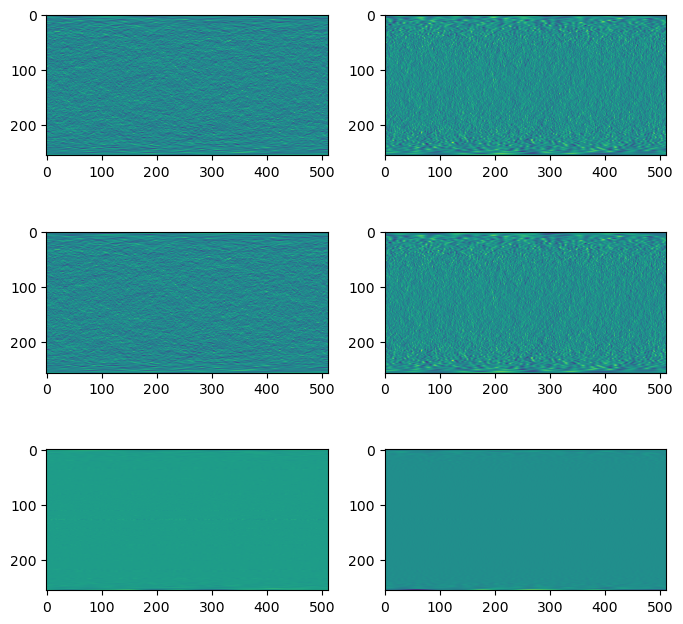

In [14]:
fig, ax = plt.subplots(3, 2, figsize=(8,8))

ax[0,0].imshow(s1tp[0,:].reshape(t.geom.ofs.size,-1))#, vmin=-1e-12, vmax=1e-12)
ax[0,1].imshow(s1tp[1,:].reshape(t.geom.ofs.size,-1))#, vmin=-1e-12, vmax=1e-12)

ax[1,0].imshow(out_spin1theta.get().T)#, vmin=-1e-7, vmax=1e-7)
ax[1,1].imshow(out_spin1phi.get().T),# vmin=-1e-8, vmax=1e-8)

ax[2,0].imshow(out_spin1theta.get().T-s1tp[0,:].reshape(t.geom.ofs.size,-1))#, vmin=-1e-12, vmax=1e-12)
ax[2,1].imshow(out_spin1phi.get().T-s1tp[1,:].reshape(t.geom.ofs.size,-1))#, vmin=-1e-12, vmax=1e-12)

In [15]:
input_value = input_values(test_case, t.geom)
out_pointingtheta = cp.zeros(t.geom.npix(), dtype=cp.float64)
out_pointingphi = cp.zeros(t.geom.npix(), dtype=cp.float64)
# Cpointing_1Dto1D(**input_value, spin1_theta=out_spin1theta.flatten(), spin1_phi=out_spin1phi.flatten(), out_ptheta=out_pointingtheta, out_pphi=out_pointingphi)
Cpointing_1Dto1D(**input_value, spin1_theta=cp.array(s1tp[1].flatten()), spin1_phi=cp.array(s1tp[0].flatten()), out_ptheta=out_pointingtheta, out_pphi=out_pointingphi)

# def2d = np.array([out_spin1theta.get()[0].T.flatten(), out_spin1phi.get()[0].T.flatten()])
def2d = s1tp.T
tht_phip_gamma = get_deflected_angles(
    theta=t.geom.theta,
    phi0=t.geom.phi0,
    nphi=t.geom.nph,
    ringstart=t.geom.ofs,
    deflect=def2d,
    calc_rotation=False,
    nthreads=10)

In [16]:
from pysht.geometry import Geom

def _sind_d_m1(d, deriv=False):
    assert np.max(d) <= 0.01, (np.max(d), 'CMB Lensing deflections should never be that big')
    d2 = d * d
    if not deriv:
        return np.poly1d([0., -1 / 6., 1. / 120., -1. / 5040.][::-1])(d2)
    else:
        return - 1. / 3. * (1. - d2 / 10. * (1. - d2 / 28.))

def d2ang(red, imd, tht, phi, version, sint_dphi=False):
    assert version in [1, 0, -1], version
    d = np.sqrt(red ** 2 + imd ** 2)
    if np.max(d) > 0.01:
        #print(np.max(d), np.max(np.abs(red)), np.max(np.abs(imd)), 'CMB Lensing deflections should never be that big')
        from scipy.special import j0
        sind_d = j0(d)
    else:
        sind_d = 1. + _sind_d_m1(d)  # sin(d) / d avoiding division by zero or near zero, assuming small deflections

    if version == 0:  #---'close' to equator, where cost ~ 0
        cost = np.cos(tht)
        assert np.max(cost < 0.8), ('wrong localization', np.max(cost))
        costp = cost * np.cos(d) - red * sind_d * np.sqrt(1. - cost ** 2) # -- cosd fine here
        dphi = np.arcsin(imd / np.sqrt(1. - costp ** 2) * sind_d) # This is unanbiguous unless d is absurdly high
        thtp = np.arccos(costp)
    else:
        isnorth = version == 1
        sint = np.sin(tht)
        # --- 'e_t' quantities are 1 \mp cos(t) with - if close to 0 and + if close to pi, such that e_t is small and > 0
        e_t = 2 * np.sin(tht * 0.5) ** 2 if isnorth else 2 * np.cos(tht * 0.5) ** 2  # 1 -+ costh with no precision loss
        e_d = 2 * np.sin(d * 0.5) ** 2

        # -- Eq. for new co-latitude (always work fine), here written for 1 - cos tht in order not to lose precision
        e_tp = e_t + e_d - e_t * e_d + version * red * sind_d * sint  # 1 -+ cost'
        sintp = np.sqrt(np.maximum(0., e_tp * (2 - e_tp)))
        if isnorth:
            assert np.max(tht) < np.pi * 0.4, ('wrong localization', np.max(tht))  # -- for the arcsin at the end
            thtp = np.arcsin(sintp)
            dphi = np.arctan2(imd * sind_d, (1. - e_d) * sint + red * sind_d * (1. - e_t))
        else:
            assert np.min(tht) > np.pi * 0.4, ('wrong localization', np.min(tht))  # -- for the arcsin at the end
            thtp = np.pi - np.arcsin(sintp)
            dphi = np.arctan2(imd * sind_d, (1. - e_d) * sint + red * sind_d * (e_t - 1.))
    if sint_dphi:
        if version == 0: # should be calculated already
            sint = np.sqrt(1. - cost * cost)
        return thtp - tht, sint * dphi
    return thtp, (phi +dphi) % (2. * np.pi)
    
def pointing_py(self, d1):
    npix = self.geom.npix()
    thp_phip_gamma = np.empty((3, npix), dtype=float)  # (-1) gamma in last arguement
    startpix = 0
    assert np.all(self.geom.theta > 0.) and np.all(self.geom.theta < np.pi), 'fix this (cotangent below)'
    red, imd = d1
    for ir in np.argsort(self.geom.ofs): # We must follow the ordering of scarf position-space map
        pixs = Geom.rings2pix(self.geom, [ir])
        if pixs.size > 0:
            t_red = red[pixs]
            i_imd = imd[pixs]
            phis = Geom.phis(self.geom, ir)[pixs - self.geom.ofs[ir]]
            assert phis.size == pixs.size, (phis.size, pixs.size)
            thts = self.geom.theta[ir] * np.ones(pixs.size)
            thtp_, phip_ = d2ang(t_red, i_imd, thts , phis, int(np.round(np.cos(self.geom.theta[ir]))))
            sli = slice(startpix, startpix + len(pixs))
            thp_phip_gamma[0, sli] = thtp_
            thp_phip_gamma[1, sli] = phip_
            cot = np.cos(self.geom.theta[ir]) / np.sin(self.geom.theta[ir])
            d = np.sqrt(t_red ** 2 + i_imd ** 2)
            thp_phip_gamma[2, sli] = np.arctan2(i_imd, t_red ) - np.arctan2(i_imd, d * np.sin(d) * cot + t_red * np.cos(d))
            startpix += len(pixs)
    print(thp_phip_gamma.T[:, 0:2].shape)
    assert startpix == npix, (startpix, npix)
    return thp_phip_gamma.T[:, 0:2]

tpg_pointing = pointing_py(t, s1tp)

(131072, 2)


In [17]:
print("Shape of out_pointingtheta: ", out_pointingtheta.shape)
print("Shape of out_pointingphi: ", out_pointingphi.shape)
print("Shape nlat, nphi: ", cGPU.nlat, cGPU.nphi)
print("Shape of tht_phip_gamma: ", tht_phip_gamma.shape)
print("Shape of tpg_pointing: ", tpg_pointing.shape)

Shape of out_pointingtheta:  (131072,)
Shape of out_pointingphi:  (131072,)
Shape nlat, nphi:  256 512
Shape of tht_phip_gamma:  (131072, 2)
Shape of tpg_pointing:  (131072, 2)


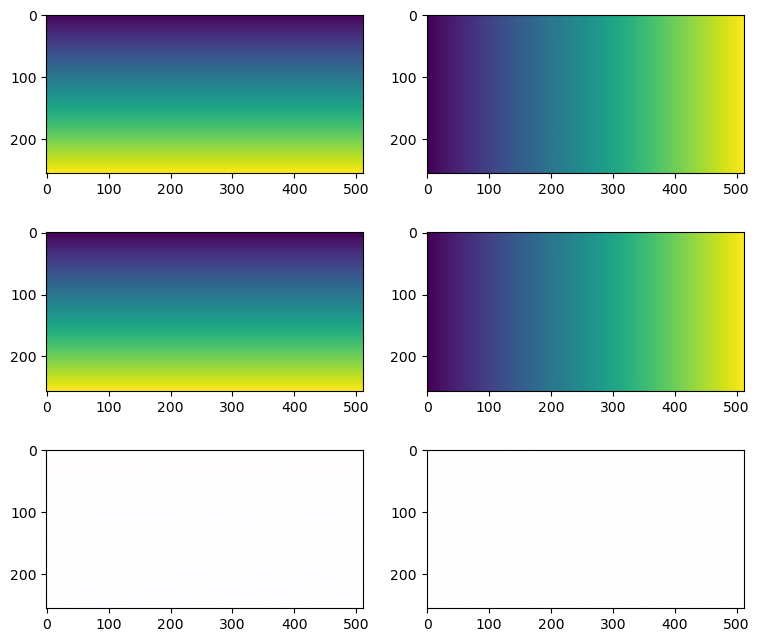

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3,2, figsize=(9,8))
ax[0,0].imshow(tht_phip_gamma[:,0].reshape(len(t.geom.theta),-1), vmin=0, vmax=np.pi)
ax[0,1].imshow(tht_phip_gamma[:,1].reshape(len(t.geom.theta),-1), vmin=0, vmax=2*np.pi)

ax[1,0].imshow(tpg_pointing[:,0].reshape(len(t.geom.theta),-1), vmin=0, vmax=np.pi)
ax[1,1].imshow(tpg_pointing[:,1].reshape(len(t.geom.theta),-1), vmin=0, vmax=2*np.pi)

ax[2,0].imshow((tpg_pointing[:,0] - tht_phip_gamma[:,0]).reshape(len(t.geom.theta),-1), vmin=-1e-1, vmax=1e-1, cmap='seismic')
ax[2,1].imshow((tpg_pointing[:,1] - tht_phip_gamma[:,1]).reshape(len(t.geom.theta),-1), vmin=-1e-1, vmax=1e-1, cmap='seismic')

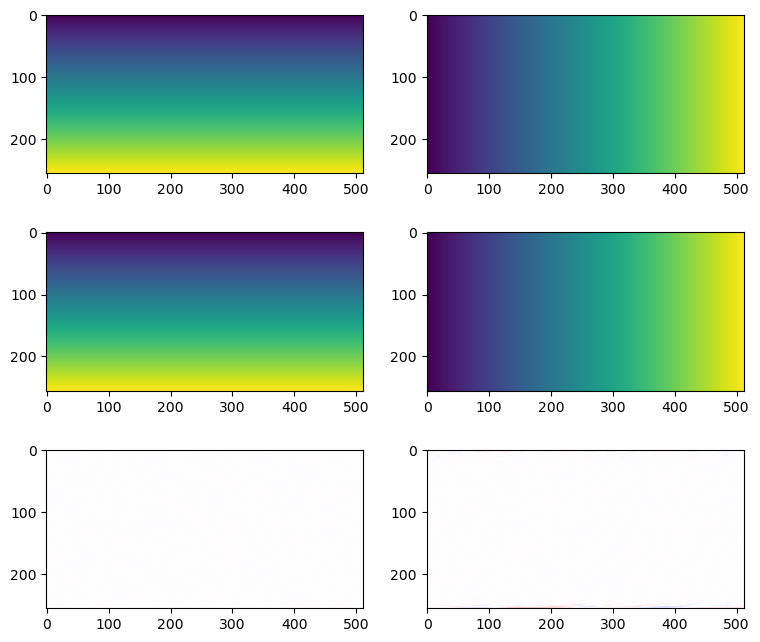

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3,2, figsize=(9,8))
ax[0,0].imshow(tpg_pointing[:,0].reshape(len(t.geom.theta),-1), vmin=0, vmax=np.pi)
ax[0,1].imshow(tpg_pointing[:,1].reshape(len(t.geom.theta),-1), vmin=0, vmax=2*np.pi)

ax[1,0].imshow(out_pointingtheta.get().reshape(len(t.geom.theta),-1), vmin=0, vmax=np.pi)
ax[1,1].imshow(out_pointingphi.get().reshape(len(t.geom.theta),-1), vmin=0, vmax=2*np.pi)

ax[2,0].imshow((tpg_pointing[:,0] - out_pointingtheta.get()).reshape(len(t.geom.theta),-1), vmin=-1e-1, vmax=1e-1, cmap='seismic')
ax[2,1].imshow((tpg_pointing[:,1] - out_pointingphi.get()).reshape(len(t.geom.theta),-1), vmin=-1e-1, vmax=1e-1, cmap='seismic')

(0.0, 512.0)

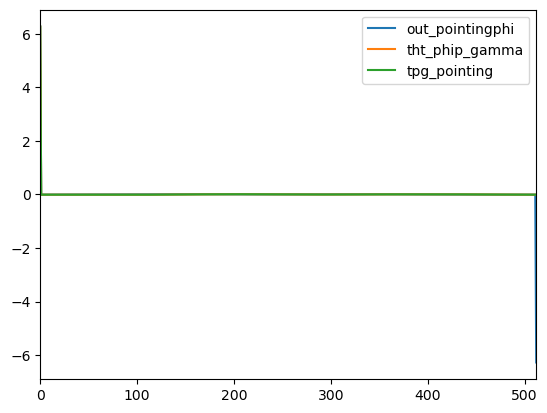

In [20]:
plt.plot(out_pointingphi.get()[:513]-(np.arange(0,513)*2*np.pi)/512, label='out_pointingphi')
plt.plot(tht_phip_gamma[:513,1]-(np.arange(0,513)*2*np.pi)/512, label='tht_phip_gamma')
plt.plot(tpg_pointing[:513,1]-(np.arange(0,513)*2*np.pi)/512, label='tpg_pointing')
plt.legend()
# plt.plot(tht_phip_gamma[:,1])
# plt.plot(out_pointingphi.get()-tht_phip_gamma[:,1])
plt.xlim(0,512)
# plt.ylim(-1e1,1e1)
# plt.ylim(4.71,4.72)

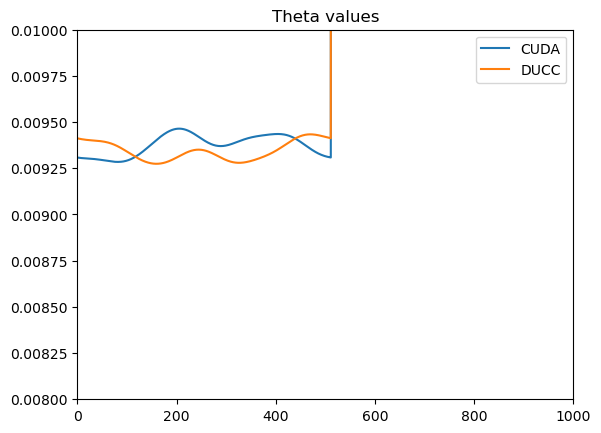

(0.0, 1000.0)

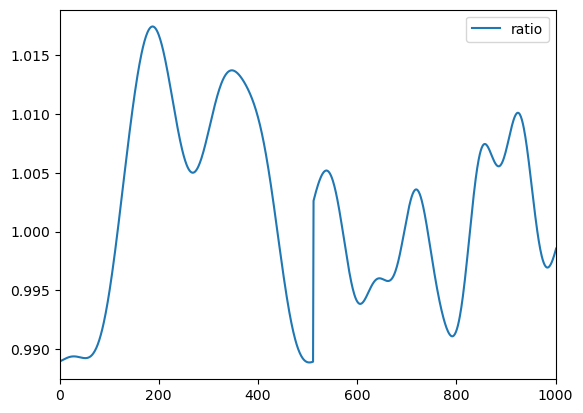

In [35]:
_lmax = 512
plt.title('Theta values')
plt.plot(out_pointingtheta.get()[:_lmax+1], label='CUDA')
plt.plot(tht_phip_gamma[:,0], label='DUCC')
plt.legend()
plt.xlim(0,1000)
plt.ylim(0.008,0.01)
plt.show()
plt.plot(out_pointingtheta.get()/tht_phip_gamma[:,0], label='ratio')
plt.legend()
plt.xlim(0,1000)

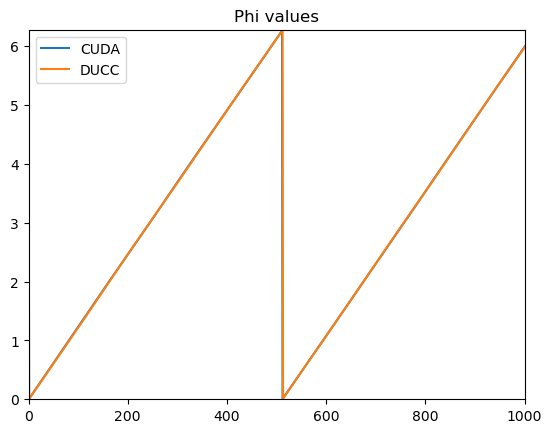

(0.0, 2.0)

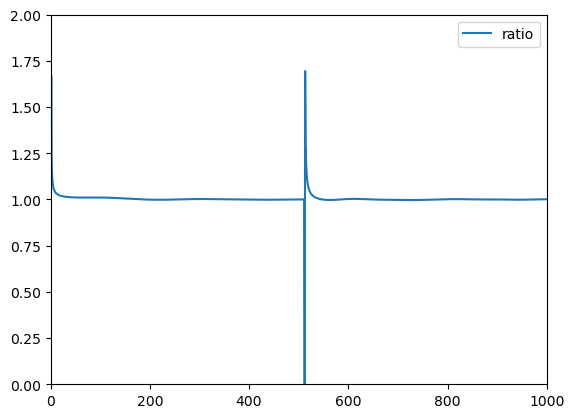

In [36]:
plt.title('Phi values')
plt.plot(out_pointingphi.get(), label='CUDA')
plt.plot(tht_phip_gamma[:,1], label='DUCC')
plt.legend()
plt.xlim(0,1000)
plt.ylim(0,2*np.pi)

plt.show()
plt.plot(out_pointingphi.get()/tht_phip_gamma[:,1], label='ratio')
plt.legend()
plt.xlim(0,1000)
plt.ylim(0,2)